In [1]:
from IPython.display import HTML, display
from datetime import datetime, timedelta
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)
plt.rc("xtick", labelsize=SMALL_SIZE)
plt.rc("ytick", labelsize=SMALL_SIZE)
plt.rc("legend", fontsize=SMALL_SIZE)
plt.rc("axes", labelsize=MEDIUM_SIZE)
plt.rc("axes", titlesize=BIGGER_SIZE)

In [3]:
CONFIG_FILE = "config.json"
LIBOR_CSV = "fred_historical_USD1MTD156N.csv"

In [4]:
START_DATE = datetime(1999, 12, 1)
END_DATE = datetime(2019, 1, 1)

In [5]:
YEARS_TO_STUDY = [
    2000,
    2004,
    2008,
    2011,
    2016,
    2018
]

In [6]:
S_P500 = "^GSPC"
STOCKS = [
    "AMZN",
    "AAPL",
    "INTC",
    "MSFT",
    "NVDA"
]
SYMBOLS = [S_P500] + STOCKS

In [7]:
def try_live_load(config_file):
    if os.path.exists(config:= os.path.join(os.getcwd(), config_file)):
        with open(config) as config_file:
            config = json.load(config_file)
            if "API_KEY" in config:
                return pd.read_json(F"https://api.tradingeconomics.com/fred/historical/USD1MTD156N?c={config['API_KEY']}").set_index(keys="date")
    return None

In [8]:
def get_risk_free_data(data_file=LIBOR_CSV, config_file=CONFIG_FILE, from_date=START_DATE+timedelta(days=1), to_date=END_DATE, keep=["value"]):
    df = try_live_load(config_file)
    if not isinstance(df, pd.DataFrame) and os.path.exists(file:= os.path.join(os.getcwd(), data_file)):
        df = pd.read_csv(file, index_col="date")
    elif not isinstance(df, pd.DataFrame):
        raise Exception("LIBOR rate data could not be imported")

    return df[keep].rename(columns={column: (F"LIBOR {column}" if len(keep) > 1 else "LIBOR") for column in df}).loc[from_date:to_date]

In [9]:
def get_risky_data(symbols, from_date=START_DATE, to_date=END_DATE, keep=["Adj Close"]):
    if isinstance(symbols, str):
        df = web.DataReader(symbols, "yahoo", from_date, to_date)[keep]
        return df.rename(columns={column: (F"{symbols} {column}" if len(keep) > 1 else symbols) for column in df})
    elif isinstance(symbols, list):
        if symbols:
            df = web.DataReader(symbols[0], "yahoo", from_date, to_date)[keep]
            df.rename(columns={column: (F"{symbols[0]} {column}" if len(keep) > 1 else symbols[0]) for column in df}, inplace=True)
            for s in symbols[1:]:
                temp = web.DataReader(s, "yahoo", from_date, to_date)[keep]
                temp.rename(columns={column: (F"{s} {column}" if len(keep) > 1 else s) for column in temp}, inplace=True)

                df = pd.merge(df, temp, how="inner", on="Date")
            return df
        else: raise ValueError("list of 'symbols' must not be empty")
    else:
        raise TypeError("'symbols' must be either a string or list of symbols")

In [10]:
stock_data = get_risky_data(SYMBOLS).sort_index()
display(HTML(stock_data.head(30).to_html()))

,^GSPC,AMZN,AAPL,INTC,MSFT,NVDA
Date,,,,,,
1999-12-01,1397.719971,85.0000,0.787944,23.193523,29.354944,0.696135
1999-12-02,1409.040039,89.0625,0.842417,23.573429,29.866838,0.747567
1999-12-03,1433.300049,86.5625,0.879210,23.915363,30.280277,0.729626
1999-12-06,1423.329956,87.7500,0.886855,23.668411,30.063709,0.749959
1999-12-07,1409.170044,86.0625,0.900712,23.459459,29.295876,0.724842
1999-12-08,1403.880005,88.5625,0.841462,22.642645,28.902121,0.757136
1999-12-09,1408.109985,103.6250,0.804668,22.262735,29.217129,0.734410
1999-12-10,1417.040039,106.6875,0.787467,21.958817,29.571510,0.726037
1999-12-13,1415.219971,102.5000,0.756886,22.509680,30.437780,0.723644


In [11]:
libor_data = get_risk_free_data().sort_index()
display(HTML(libor_data.head().to_html()))

libor_data = np.log(libor_data/100 + 1)
display(HTML(libor_data.head().to_html()))

,LIBOR
date,
1999-12-02,6.47875
1999-12-03,6.47875
1999-12-06,6.46875
1999-12-07,6.46750
1999-12-08,6.46875


,LIBOR
date,
1999-12-02,0.062775
1999-12-03,0.062775
1999-12-06,0.062681
1999-12-07,0.062670
1999-12-08,0.062681


In [12]:
libor_daily = libor_data.groupby(by=libor_data.index.year).apply(lambda df: df.mean()/360)
display(HTML(libor_daily.to_html()))

,LIBOR
date,
1999,0.000172
2000,0.000173
2001,0.000105
2002,0.000049
2003,0.000033
2004,0.000041
2005,0.000092
2006,0.000138
2007,0.000142


In [13]:
libor_monthly = libor_data.groupby(by=libor_data.index.year).apply(lambda df: df.mean()/12)
display(HTML(libor_monthly.to_html()))

,LIBOR
date,
1999,0.005170
2000,0.005179
2001,0.003165
2002,0.001460
2003,0.001001
2004,0.001241
2005,0.002775
2006,0.004141
2007,0.004262


In [14]:
K_daily = np.log(stock_data / stock_data.shift(1))
display(HTML(K_daily.head().to_html()))

,^GSPC,AMZN,AAPL,INTC,MSFT,NVDA
Date,,,,,,
1999-12-01,NaN,NaN,NaN,NaN,NaN,NaN
1999-12-02,0.008066,0.046687,0.066848,0.016247,0.017288,0.071281
1999-12-03,0.017071,-0.028472,0.042749,0.014401,0.013748,-0.024292
1999-12-06,-0.006980,0.013625,0.008657,-0.010380,-0.007178,0.027487
1999-12-07,-0.009998,-0.019418,0.015504,-0.008868,-0.025872,-0.034066


In [15]:
stock_data_bom = stock_data.groupby(by=[stock_data.index.year, stock_data.index.month]).first()
display(HTML(stock_data_bom.head().to_html()))
K_monthly = np.log(stock_data_bom / stock_data_bom.shift(1))
display(HTML(K_monthly.head().to_html()))

In [16]:
def mvp(C_inv, m, ones):
    sigma = np.squeeze(1 / np.sqrt(ones.T @ C_inv @ ones))
    w = sigma ** 2 * (C_inv @ ones)
    mu = np.squeeze(m.T @ w)
    return w, sigma, mu

In [17]:
def mp(C, C_inv, m, R, ones):
    m_ex = m - R * ones

    w = (1 / np.squeeze(ones.T @ C_inv @ m_ex)) * (C_inv @ m_ex)
    sigma = np.squeeze(np.sqrt(w.T @ C @ w))
    mu = np.squeeze(m.T @ w)
    return w, sigma, mu

In [18]:
def generate_efficient_frontier(C_inv, m, mu_MVP, mu_M):
    m_bar = np.concatenate((m, ones), axis=1)
    
    B = m_bar.T @ C_inv @ m_bar
    B_inv = np.linalg.inv(B)

    G = B_inv @ m_bar.T @ C_inv @ m_bar @ B_inv

    a = G[0, 0]
    d = G[0, 1]

    mu = np.linspace(mu_MVP, mu_M*(1.5 if mu_M > 0 else .5), 1000)
    sigma = np.sqrt(a*(mu + (d/a))**2 + (1/a)*np.linalg.det(G))
    return sigma, mu

In [19]:
def capm(mu_M, R, sigma_M, sigma_v):
    beta = np.linspace(0, max(sigma_v)/sigma_M, 1000)
    mu_v = beta * (mu_M - R) + R
    return beta, mu_v

[[0.06365994 0.02940101 0.03066052 0.02691073 0.03817524]
 [0.02940101 0.0639576  0.03453588 0.02358166 0.03431897]
 [0.03066052 0.03453588 0.04376425 0.02692745 0.03293385]
 [0.02691073 0.02358166 0.02692745 0.03572982 0.03208029]
 [0.03817524 0.03431897 0.03293385 0.03208029 0.07457434]]
[[ 0.08041868]
 [ 0.09336945]
 [ 0.22092925]
 [ 0.61504286]
 [-0.00976024]]
Adjusting R:
	LIBOR rate: 0.00017264348302361884 >~ mu_MVP -0.0036698495940198357


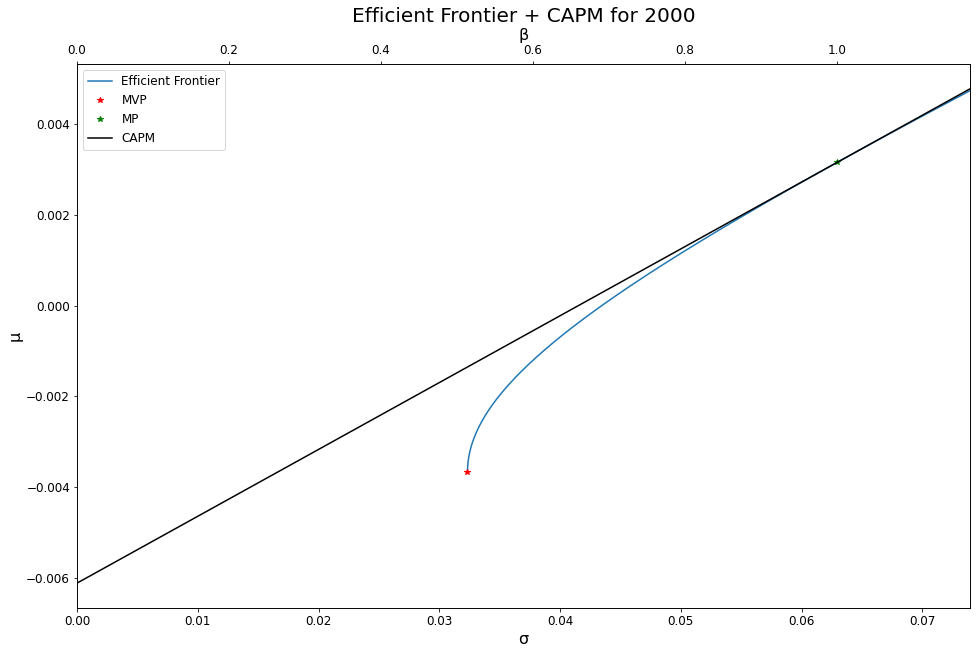

,Year,σ_MVP,μ_MVP,LIBOR,R,σ_M,μ_M
0,2000,0.032334,-0.00367,0.000173,-0.006116,0.062949,0.003157



[[0.02693192 0.01178326 0.01176375 0.00992427 0.01742428]
 [0.01178326 0.02498125 0.01108812 0.00848448 0.0154981 ]
 [0.01176375 0.01108812 0.01924231 0.00976259 0.01914745]
 [0.00992427 0.00848448 0.00976259 0.01074926 0.01158649]
 [0.01742428 0.0154981  0.01914745 0.01158649 0.03997382]]
[[ 0.02060725]
 [ 0.0699998 ]
 [ 0.07881791]
 [ 0.86719725]
 [-0.03662221]]


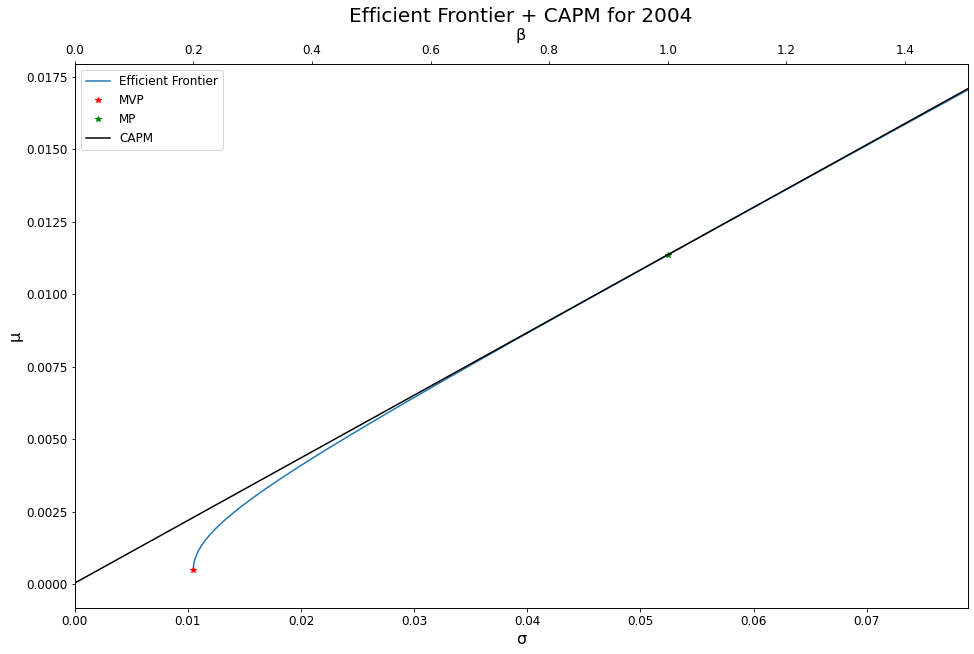

,Year,σ_MVP,μ_MVP,LIBOR,R,σ_M,μ_M
0,2004,0.010482,0.000494,0.000041,0.000041,0.052415,0.011363



[[0.04131767 0.03179377 0.02936147 0.02843447 0.03235683]
 [0.03179377 0.03699773 0.02784258 0.02611769 0.03083633]
 [0.02936147 0.02784258 0.0334176  0.02733158 0.03430068]
 [0.02843447 0.02611769 0.02733158 0.03024171 0.02880007]
 [0.03235683 0.03083633 0.03430068 0.02880007 0.05423302]]
[[-0.02770762]
 [ 0.20938796]
 [ 0.27457823]
 [ 0.59896525]
 [-0.05522383]]
Adjusting R:
	LIBOR rate: 7.346458134416215e-05 >~ mu_MVP -0.002326868286824059


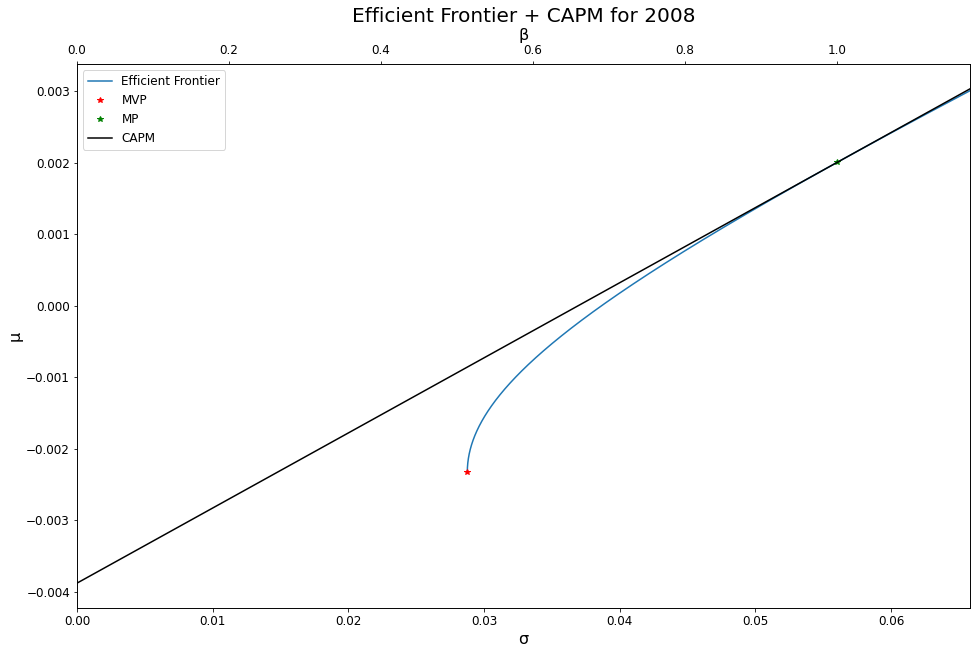

,Year,σ_MVP,μ_MVP,LIBOR,R,σ_M,μ_M
0,2008,0.028767,-0.002327,0.000073,-0.003878,0.05602,0.002005



[[0.02433644 0.01462047 0.01349539 0.01413096 0.019153  ]
 [0.01462047 0.01653581 0.012028   0.01191036 0.01769998]
 [0.01349539 0.012028   0.01714938 0.01295402 0.01825783]
 [0.01413096 0.01191036 0.01295402 0.01478702 0.0175132 ]
 [0.019153   0.01769998 0.01825783 0.0175132  0.03605112]]
[[-0.02821655]
 [ 0.37837856]
 [ 0.2435833 ]
 [ 0.55681736]
 [-0.15056267]]


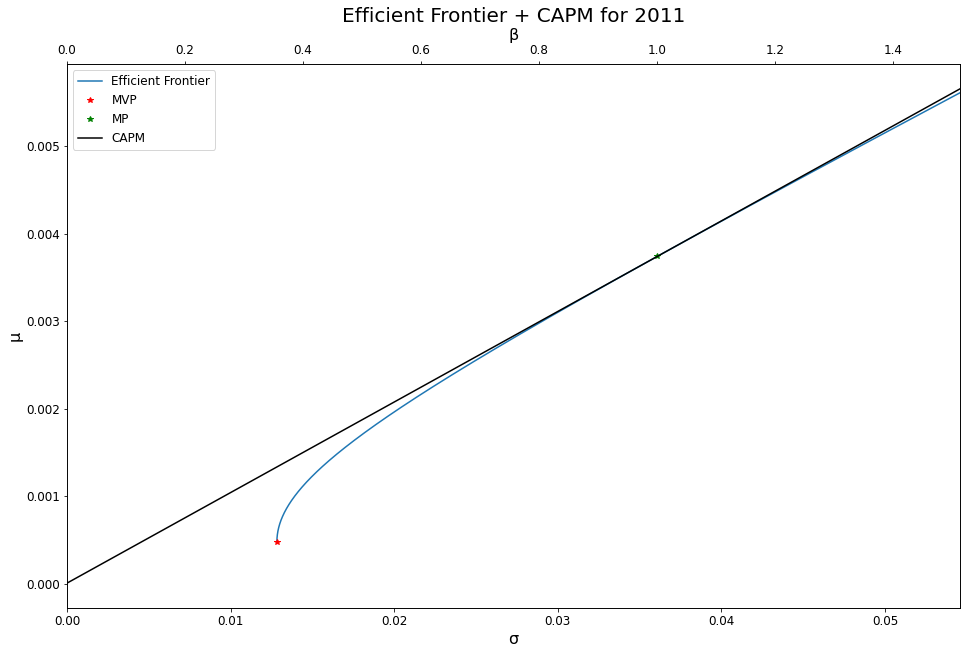

,Year,σ_MVP,μ_MVP,LIBOR,R,σ_M,μ_M
0,2011,0.012825,0.000478,0.000006,0.000006,0.03607,0.003739



[[0.01868182 0.00990377 0.00983905 0.01156125 0.01185527]
 [0.00990377 0.01472327 0.00986737 0.01020091 0.011102  ]
 [0.00983905 0.00986737 0.01431989 0.0111375  0.01318143]
 [0.01156125 0.01020091 0.0111375  0.01430902 0.01217836]
 [0.01185527 0.011102   0.01318143 0.01217836 0.02798885]]
[[ 0.12780139]
 [ 0.32541258]
 [ 0.3257548 ]
 [ 0.23671366]
 [-0.01568244]]


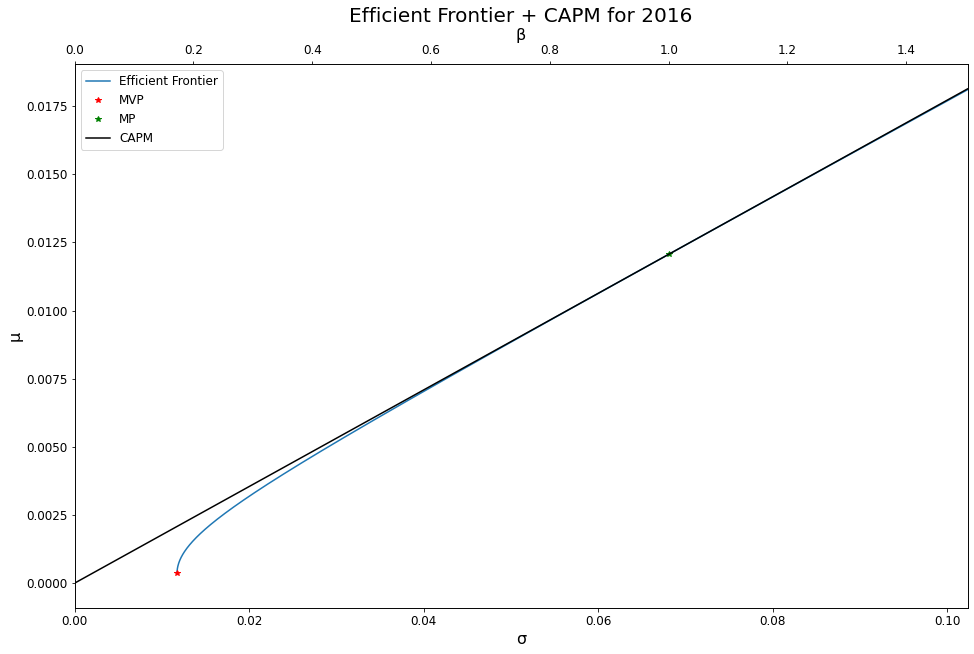

,Year,σ_MVP,μ_MVP,LIBOR,R,σ_M,μ_M
0,2016,0.011726,0.000371,0.000014,0.000014,0.068062,0.012059



[[0.02277627 0.01650313 0.01558923 0.01771219 0.02148433]
 [0.01650313 0.01812624 0.01443816 0.0149899  0.01716239]
 [0.01558923 0.01443816 0.02136371 0.0155538  0.0190885 ]
 [0.01771219 0.0149899  0.0155538  0.0177865  0.01873815]
 [0.02148433 0.01716239 0.0190885  0.01873815 0.03174859]]
[[-0.04184072]
 [ 0.43799846]
 [ 0.2006832 ]
 [ 0.50442187]
 [-0.10126281]]


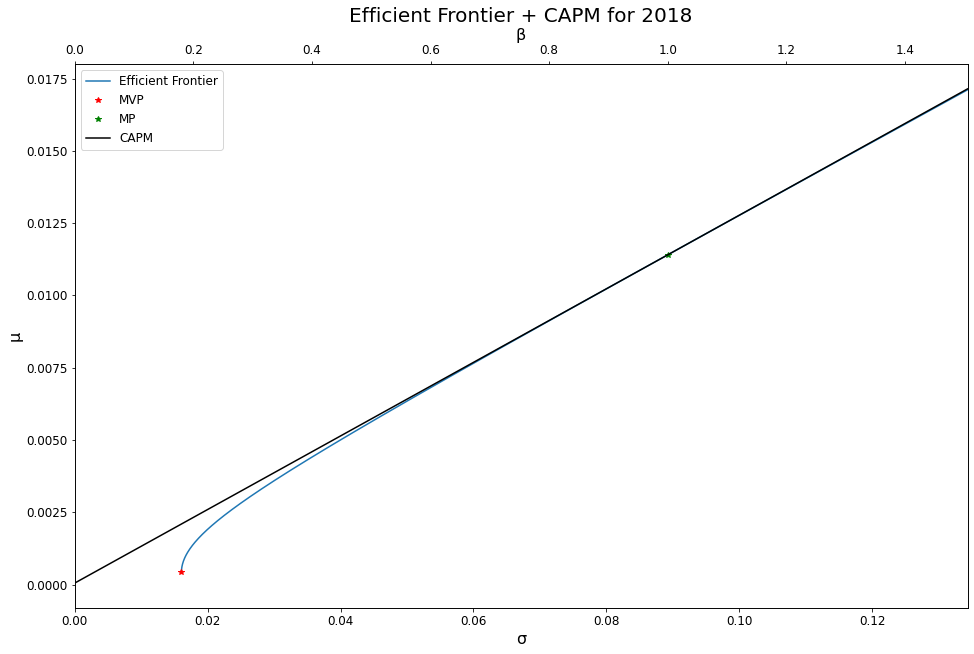

,Year,σ_MVP,μ_MVP,LIBOR,R,σ_M,μ_M
0,2018,0.016058,0.000423,0.000056,0.000056,0.089256,0.011407


In [20]:
for year in YEARS_TO_STUDY:
    df = pd.DataFrame(data={"Year": [year]})

    K = K_daily[STOCKS].loc[datetime(year, 1, 1):datetime(year+1, 1, 1)]

    ## 1
    m = K.mean().to_frame(name="m")

    C = np.cov(K.values, rowvar=False)
    print(np.sqrt(C))
    ## 2
    ones = np.ones((C.shape[0], 1))
    C_inv = np.linalg.inv(C)

    w_MVP, sigma_MVP, mu_MVP = mvp(C_inv, m.values, ones)

    print(w_MVP)
    df["σ_MVP"] = sigma_MVP
    df["μ_MVP"] = mu_MVP

    R = np.squeeze(libor_daily.loc[year].values)
    df["LIBOR"] = R
    if R >= (.9 if mu_MVP > 0 else 1.1)*mu_MVP:
        print("Adjusting R:")
        print(F"\tLIBOR rate: {R} >~ mu_MVP {mu_MVP}")
        R = ((1/3) if mu_MVP > 0 else (5/3))*mu_MVP
    df["R"] = R

    w_M, sigma_M, mu_M = mp(C, C_inv, m.values, R, ones)

    df["σ_M"] = sigma_M
    df["μ_M"] = mu_M

    ## 3
    sigma_v, mu_v = generate_efficient_frontier(C_inv, m.values, mu_MVP, mu_M)
    beta, mu_v_capm = capm(mu_M, R, sigma_M, sigma_v)

    fig = plt.figure(figsize=(16, 10))
    ax1 = fig.add_subplot(111)

    ef = ax1.plot(sigma_v, mu_v, label="Efficient Frontier")
    mvp_p = ax1.plot(sigma_MVP, mu_MVP, "r*", label="MVP")
    mp_p = ax1.plot(sigma_M, mu_M, "g*", label="MP")

    ax2 = ax1.twiny()
    capm_l = ax2.plot(beta, mu_v_capm, "black", label="CAPM")

    lines = ef + mvp_p + mp_p + capm_l
    ax1.legend(lines, [l.get_label() for l in lines])

    ax1.set_title(F"Efficient Frontier + CAPM for {year}")
    ax1.set_xlabel("σ")
    ax2.set_xlabel("β")
    ax1.set_ylabel("μ")
    ax1.set_xlim(0, max(sigma_v))
    ax2.set_xlim(min(beta), max(beta))
    plt.show()

    display(HTML(df.to_html()))

    print()